__Basic Imports including Dataframes__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import shap
from statistics import mean, stdev
import seaborn as sns
from statannot import add_stat_annotation
from matplotlib.patches import Patch
from dna_features_viewer import GraphicFeature, GraphicRecord

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import f1_score, roc_curve, RocCurveDisplay
from sklearn.metrics import accuracy_score, balanced_accuracy_score,roc_auc_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import ConfusionMatrixDisplay

#dataframe importing

model_proteins = pd.read_csv('austin_db/model_proteins_final.csv')
model_region = pd.read_csv('austin_db/model_regions_final.csv')
model_peptides = pd.read_csv('austin_db/model_peptides_final.csv')
kathi_features = pd.read_csv('austin_db/kathi_features_fresh.csv')
proteinfeatures = pd.read_csv('austin_db/proteinfeatures.csv')

In [2]:
#combining dataframes
model_proteins = model_proteins.rename(columns={'Protein_Sequence':'Sequence'})
new_features_df = pd.merge(model_proteins, kathi_features, on='Sequence')

In [3]:
#housekeeping

new_features_df['Phosphorylation'].loc[new_features_df['Phosphorylation'] != 0] = 1
new_features_df['Acetylation'].loc[new_features_df['Acetylation'] != 0] = 1
new_features_df['Methylation'].loc[new_features_df['Methylation'] != 0] = 1
new_features_df['Phosphorylation'].loc[new_features_df['Phosphorylation'] != 0] = 1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
#making it only kathi's features with classifications and protein id

only_kathi_features_df = new_features_df.drop(['Acetylation','Methylation','Glycosylation','Phosphorylation'], axis=1)
only_kathi_features_df = only_kathi_features_df.drop(['Ubiquitination','Cleavage','Beta','Binding','Disordered','Turn','Polar','Helical','Basic','Cytoplasmic','Extracellular_x','Coiled','Initiator_Methionine','Transmembrane','Signal_Peptide','Signal_Mitochrondrion','Anchor','GPI','Isoforms','Disulfide','A_x','R_x','N_x','D_x','C_x','Q_x','E_x','G_x','H_x','I_x','L_x','K_x','M_x','F_x','P_x','S_x','T_x','W_x','Y_x','V_x','O','U','B','Z','J','X','MZ','Charge','Weight','Hydrophobicity','Hydrophobic_Moment','Instability','Structure'],axis=1)
only_kathi_features_df = only_kathi_features_df.drop(['Coverage','Sequence','Number_Peptides','Overlapping_Peptides','Mean_Peptide_Length','Protein_Length','Seqdict'], axis=1)      

In [5]:
# Using replace to clarify terminology. Negative = Not Secreted. Positive = Fully Secreted. Mixed = Mixed.
only_kathi_features_df.replace('Positive','Fully_Secreted',inplace=True)
only_kathi_features_df.replace('Negative','Not_Secreted',inplace=True)
only_kathi_features_df.replace('Mixed','Partially_Secreted',inplace=True)

In [6]:
'''
Test the robustness of the machine learning model by perfoming repeated stratified K fold with the random forest model
'''
def RobustnessTest(X_train,y_train):
    skf = RepeatedStratifiedKFold(n_splits=5,n_repeats=3)
    acc = []
    bacc = []
    auc = []
    f1 = []

    for train_index, test_index in skf.split(X_train, y_train):
        x_train_fold, x_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        rf_model = BalancedRandomForestClassifier()  
        # under sample training data
        rf_model.fit(x_train_fold, y_train_fold)
        y_pred = rf_model.predict(x_test_fold)
        acc.append(accuracy_score(y_test_fold, y_pred))
        bacc.append(balanced_accuracy_score(y_test_fold, y_pred))
        auc.append(roc_auc_score(y_test_fold, y_pred))
        f1.append(f1_score(y_test_fold, y_pred))
    return acc,bacc,auc,f1

__Below is a baseline version of Two Class Random Forest__

Not_Secreted vs Rest y value counts
 0    3938
1    1409
Name: Filtered_Classification, dtype: int64
ACC: 0.765648558051411 BACC 0.7621804560565623 AUC: 0.8373631961694927 F1: 0.6292812061797594
Fully_Secreted vs Rest y value counts
 0    4995
1     352
Name: Filtered_Classification, dtype: int64
ACC: 0.8618190595908254 BACC 0.8700434989225253 AUC: 0.9373714285714287 F1: 0.4569708159381183


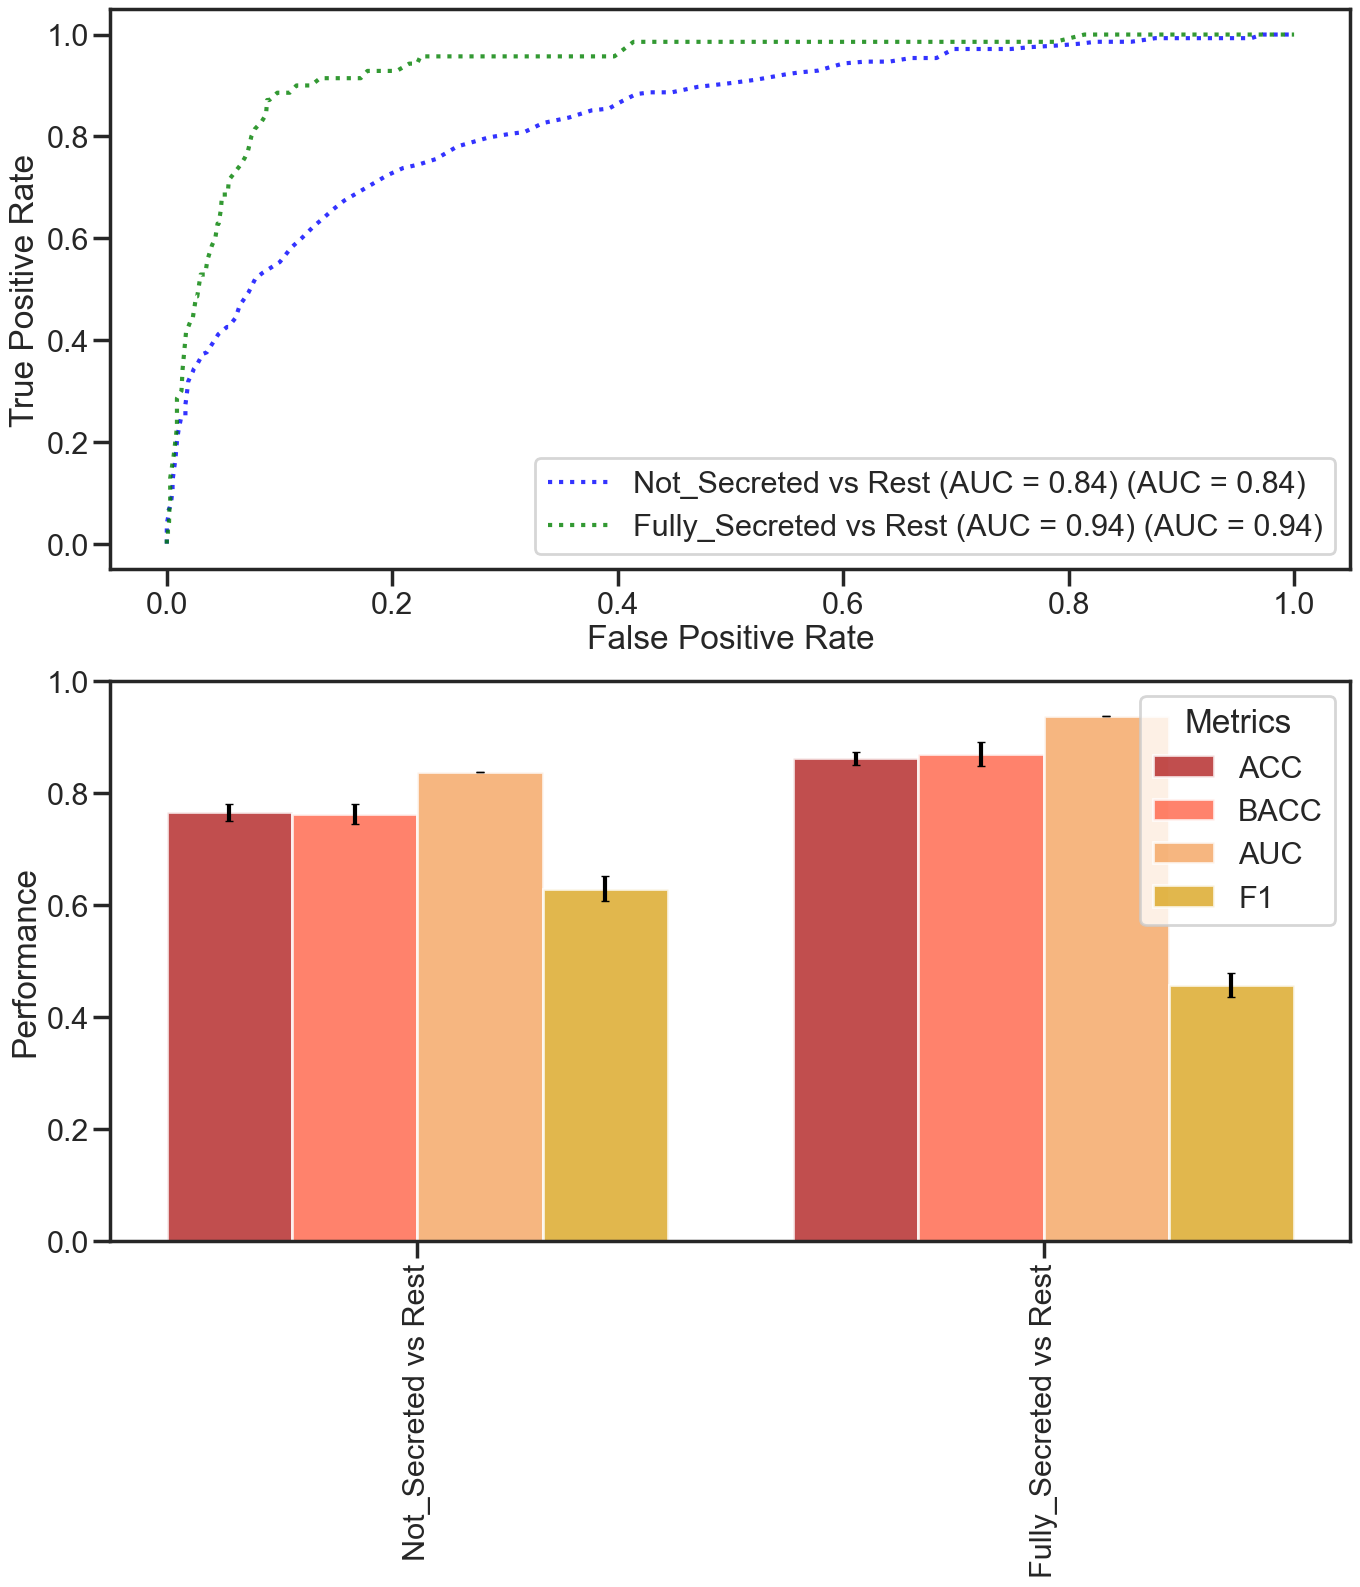

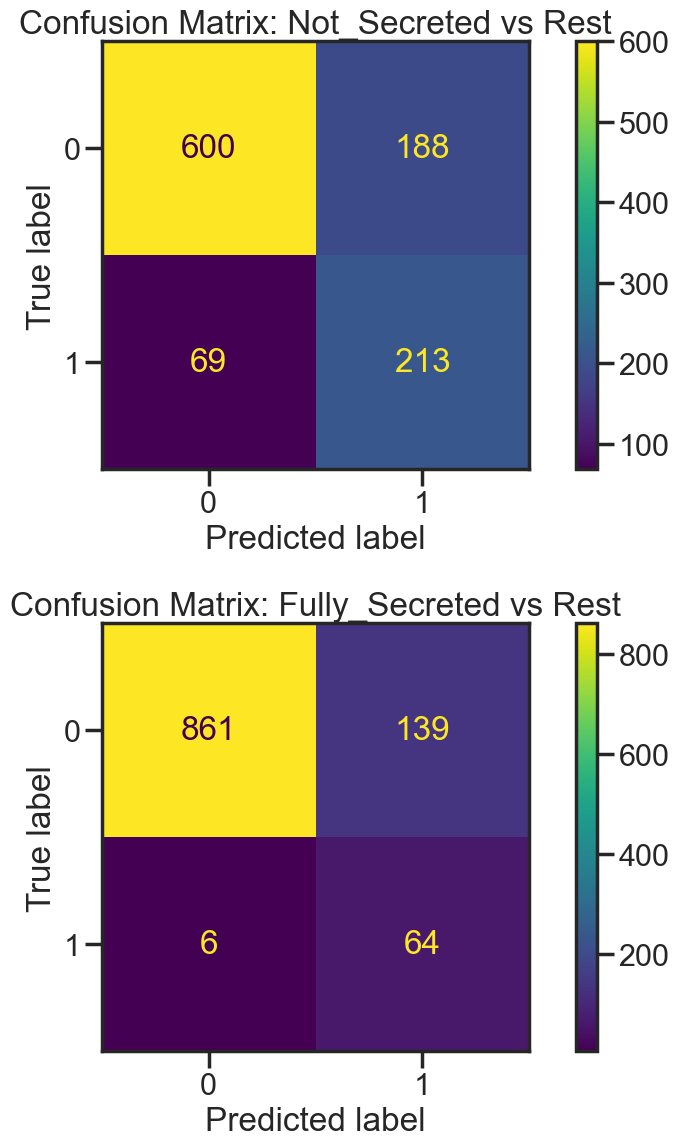

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
import numpy as np
from statistics import mean, stdev

sns.set_style("ticks")
sns.set_context("poster")

proteinmodel_results = {}
testlist = {
    'Not_Secreted vs Rest': [{'Not_Secreted': 0, 'Fully_Secreted': 1, 'Partially_Secreted': 1}, 'Filtered_Classification'],
    'Fully_Secreted vs Rest': [{'Not_Secreted': 0, 'Fully_Secreted': 1, 'Partially_Secreted': 0}, 'Filtered_Classification'],
}

fig, ax = plt.subplots(2, 1, figsize=(16, 16))
fig_conf, ax_conf = plt.subplots(len(testlist), 1, figsize=(10, 6 * len(testlist)))  # Figure for confusion matrices

# Colors for the bar plots
colors = {
    'ACC': 'firebrick',
    'BACC': 'tomato',
    'AUC': 'sandybrown',
    'F1': 'goldenrod'
}

# Adjusting labels and layout
bar_width = 0.2

for i, test_name in enumerate(testlist):
    # Changes Classification
    data = only_kathi_features_df.copy()
    data[testlist[test_name][1]] = data[testlist[test_name][1]].map(testlist[test_name][0])
    data = data[data[testlist[test_name][1]] != 2]
    data = data.mask(data[testlist[test_name][1]].eq('None')).dropna()

    # Create X and Y
    X = data.drop(['CSF', 'Uniprot', 'Protein', 'Classification', 'Filtered_Classification', 'Region_Classification'], axis=1)
    y = data[testlist[test_name][1]]
    print(test_name, 'y value counts\n', y.value_counts())

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # Create models
    rf_model = BalancedRandomForestClassifier(random_state=42)

    # Test for robustness on training split
    acc, bacc, auc_train, f1 = RobustnessTest(X_train, y_train)

    # Tests model on test split after training
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
    auc_test = roc_auc_score(y_test, y_pred_proba)  # Calculate AUC for the test set
    proteinmodel_results.update({test_name: [acc, bacc, auc_test, f1]})

    # Plot ROC curve
    if 'MvsBO' in test_name:
        colour = 'orange'
    elif 'Not_Secreted vs Rest' in test_name:
        colour = 'b'
    elif 'MvsCSF' in test_name:
        colour = 'cyan'
    else:
        colour = 'g'
    if 'STR' in test_name:
        ls = 'dashed'
    elif '_S' in test_name:
        ls = 'dotted'
    else:
        ls = 'solid'

    RocCurveDisplay.from_estimator(rf_model, X_test, y_test, ax=ax[0], alpha=0.8, color=colour, linestyle=ls, name=f"{test_name} (AUC = {auc_test:.2f})")

    # Update bar plot with the calculated AUC for the test set
    ax[1].bar(i - bar_width * 1.5, mean(acc), yerr=stdev(acc), align='center', alpha=0.8, ecolor='black', capsize=3, width=bar_width, color=colors['ACC'], label='ACC' if i == 0 else "")
    ax[1].bar(i - bar_width * 0.5, mean(bacc), yerr=stdev(bacc), align='center', alpha=0.8, ecolor='black', capsize=3, width=bar_width, color=colors['BACC'], label='BACC' if i == 0 else "")
    ax[1].bar(i + bar_width * 0.5, auc_test, yerr=0, align='center', alpha=0.8, ecolor='black', capsize=3, width=bar_width, color=colors['AUC'], label='AUC' if i == 0 else "")
    ax[1].bar(i + bar_width * 1.5, mean(f1), yerr=stdev(f1), align='center', alpha=0.8, ecolor='black', capsize=3, width=bar_width, color=colors['F1'], label='F1' if i == 0 else "")
    print('ACC:', mean(acc), 'BACC', mean(bacc), 'AUC:', auc_test, 'F1:', mean(f1))

    # Plot confusion matrix (new)
    conf_matrix = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(conf_matrix, display_labels=rf_model.classes_).plot(ax=ax_conf[i])
    ax_conf[i].set_title(f'Confusion Matrix: {test_name}')

# Adjust the ticks and labels
ax[1].set_xticks(np.arange(len(testlist)))
ax[1].set_xticklabels(testlist.keys())
ax[0].set_xlabel('False Positive Rate', fontsize=24)
ax[0].set_ylabel('True Positive Rate', fontsize=24)
ax[1].set_ylabel('Performance', fontsize=24)
ax[1].legend(title='Metrics')
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_ylim([0, 1])

# Save the graphs and display
plt.tight_layout()
fig.savefig('final_figures/Two_Class_Baseline.png', dpi=300, bbox_inches="tight")
fig_conf.savefig('final_figures/Two_Class_Baseline_Confusion_Matrices.png', dpi=300, bbox_inches="tight")
plt.show()


__Feature Importance for Fully Secreted vs Rest__

PermutationExplainer explainer: 1071it [02:35,  6.44it/s]                       


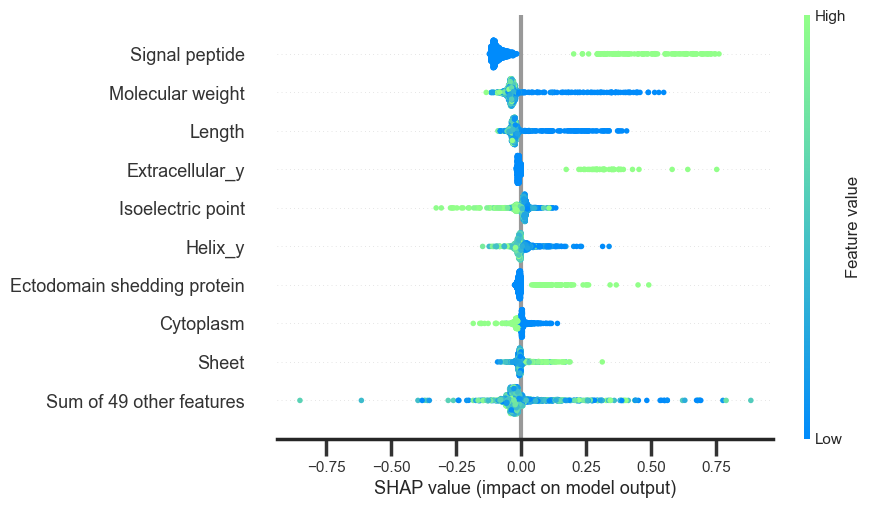

In [18]:
# Fits the explainer
explainer = shap.Explainer(shaprf.predict, shap_X_test)

#Color Mapper
newCmap = LinearSegmentedColormap.from_list("", ['#008bfb','#92FF89'])

# Calculates the SHAP values - It takes some time
shap_values = explainer(shap_X_test)
shap.plots.beeswarm(shap_values,color=newCmap,show=False)
plt.savefig('final_figures/Two_Class_Baseline_Fully_Secreted_SHAP.png',dpi=300, bbox_inches = "tight")

In [21]:
# Calculate feature importance by summing the absolute SHAP values across all samples
feature_importance = np.abs(shap_values.values).mean(axis=0)

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': shap_values.feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10-15 most important features
top_features = importance_df.head(15)
print(top_features)

                        Feature  Importance
30               Signal peptide    0.132350
3              Molecular weight    0.057277
2                        Length    0.039679
36              Extracellular_y    0.023482
24            Isoelectric point    0.021867
27                      Helix_y    0.021222
56  Ectodomain shedding protein    0.015297
35                    Cytoplasm    0.014655
29                        Sheet    0.013945
10                          H_y    0.011630
18                          R_y    0.010376
15                          N_y    0.009661
39                Cell membrane    0.008335
1                    Unnamed: 0    0.007943
11                          I_y    0.007937


In [22]:
# Finding the average value 
average_value = importance_df['Importance'].mean()

print("Average value of the column:", average_value)

Average value of the column: 0.00929773606187561


In [23]:
# Boolean indexing to isolate values above the average
above_average_values = importance_df[importance_df['Importance'] > average_value]

print("Values above the average:")
print(above_average_values['Feature'].tolist())

Values above the average:
['Signal peptide', 'Molecular weight', 'Length', 'Extracellular_y', 'Isoelectric point', 'Helix_y', 'Ectodomain shedding protein', 'Cytoplasm', 'Sheet', 'H_y', 'R_y', 'N_y']


In [25]:
# Boolean indexing to isolate values UNDER the average
below_average_values = importance_df[importance_df['Importance'] < average_value]

print("Values below the average:")
print(below_average_values['Feature'].tolist())

Values below the average:
['Cell membrane', 'Unnamed: 0', 'I_y', 'K_y', 'Mitochondrion', 'C_y', 'T_y', 'G_y', 'V_y', 'E_y', 'P_y', 'Coil', 'M_y', 'W_y', 'Disorder', 'L_y', 'Instability index', 'Q_y', 'TM region', 'Y_y', 'F_y', 'D_y', 'A_y', 'TM region (binary)', 'S_y', 'Helix_x', 'Nucleus', 'N-linked Glycosylation (GlycoMine)', 'EV', 'RNA binding', 'GPI-anchor', 'O-linked Glycosylation (GlycoMine)', 'Golgi apparatus', 'Endoplasmic reticulum', 'NetNGlyc', 'DNA binding', 'Lysosome/Vacuole', 'Peroxisome', 'Plastid', 'EGF1', 'EGF2', 'Homeobox', 'Zinc Finger C2H2', 'G-protein receptor F1', 'Cadherin-1', 'C-linked Glycosylation (GlycoMine)']


__TSNE Visualizations for all Features and Reduced Feautres *(Should Single out Fully Secreted Proteins)*__

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5347 samples in 0.001s...
[t-SNE] Computed neighbors for 5347 samples in 0.481s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5347
[t-SNE] Computed conditional probabilities for sample 2000 / 5347
[t-SNE] Computed conditional probabilities for sample 3000 / 5347
[t-SNE] Computed conditional probabilities for sample 4000 / 5347
[t-SNE] Computed conditional probabilities for sample 5000 / 5347
[t-SNE] Computed conditional probabilities for sample 5347 / 5347
[t-SNE] Mean sigma: 1.962746
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.199753
[t-SNE] KL divergence after 3000 iterations: 1.619802


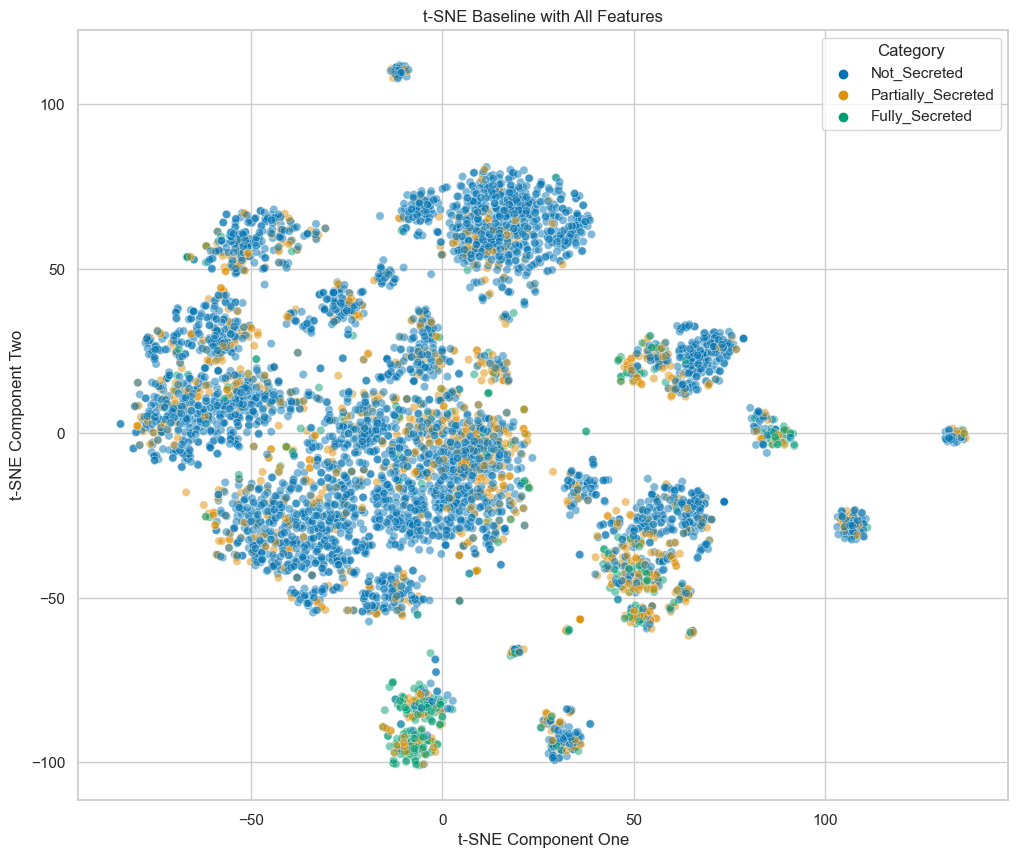

In [28]:
#TSNE with Kathi's Features on the Filtered Classification Level.

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

features = only_kathi_features_df.drop(['CSF', 'Uniprot','Protein','Classification','Filtered_Classification','Region_Classification'], axis=1)
labels = only_kathi_features_df['Filtered_Classification']
features_scaled = StandardScaler().fit_transform(features)

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=3000,random_state=42)
tsne_results = tsne.fit_transform(features_scaled)

tsne_df = pd.DataFrame(tsne_results, columns=['tsne-2d-one', 'tsne-2d-two'])
tsne_df['Category'] = labels

# Plot the results
sns.set(style="whitegrid")
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=tsne_df,
    x='tsne-2d-one', y='tsne-2d-two',
    hue='Category',
    palette='colorblind',  # Choose a color palette
    alpha = 0.5
)

# Set labels and title
plt.xlabel('t-SNE Component One')
plt.ylabel('t-SNE Component Two')
plt.title('t-SNE Baseline with All Features')

plt.savefig('final_figures/TSNE_All_Features_Baseline.png',dpi=300, bbox_inches = "tight")

plt.show()


The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5347 samples in 0.005s...
[t-SNE] Computed neighbors for 5347 samples in 0.455s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5347
[t-SNE] Computed conditional probabilities for sample 2000 / 5347
[t-SNE] Computed conditional probabilities for sample 3000 / 5347
[t-SNE] Computed conditional probabilities for sample 4000 / 5347
[t-SNE] Computed conditional probabilities for sample 5000 / 5347
[t-SNE] Computed conditional probabilities for sample 5347 / 5347
[t-SNE] Mean sigma: 0.719205
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.013260
[t-SNE] KL divergence after 3000 iterations: 1.452804


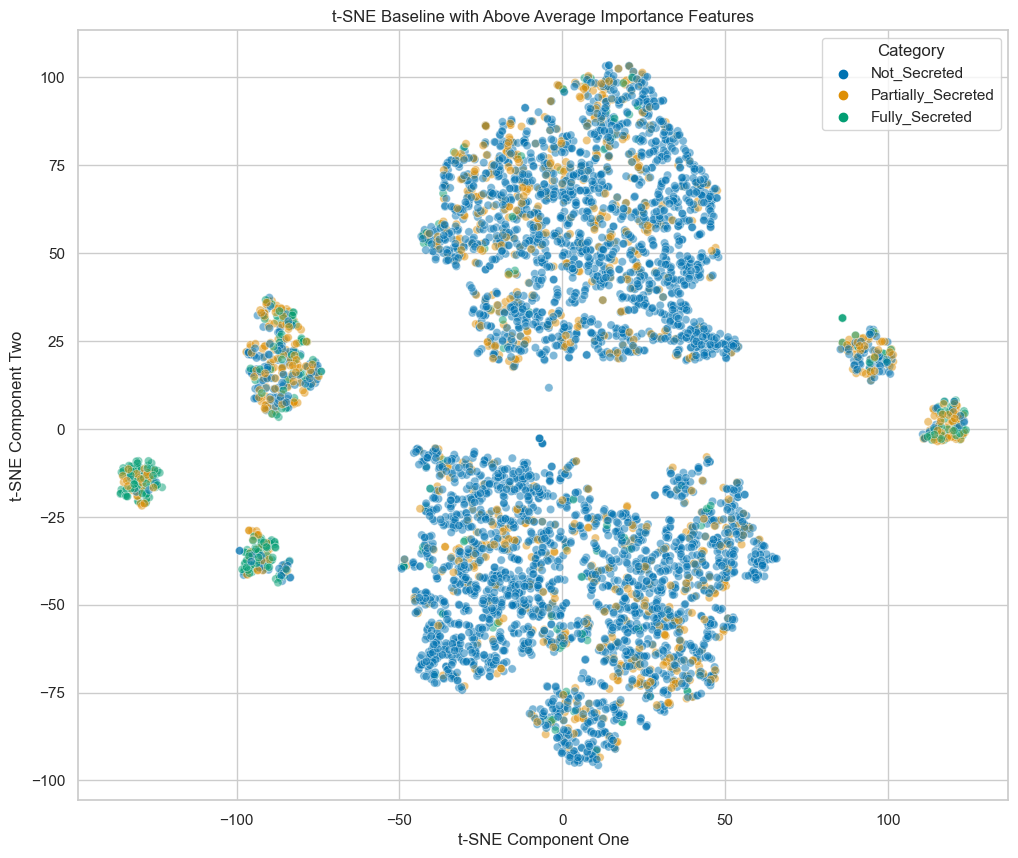

In [30]:
#TSNE with Kathi's Features on the Filtered Classification Level.

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

features = only_kathi_features_df.drop(['CSF', 'Uniprot','Protein','Classification','Filtered_Classification','Region_Classification', 'Cell membrane', 'Unnamed: 0', 'I_y', 'K_y', 'Mitochondrion', 'C_y', 'T_y', 'G_y', 'V_y', 'E_y', 'P_y', 'Coil', 'M_y', 'W_y', 'Disorder', 'L_y', 'Instability index', 'Q_y', 'TM region', 'Y_y', 'F_y', 'D_y', 'A_y', 'TM region (binary)', 'S_y', 'Helix_x', 'Nucleus', 'N-linked Glycosylation (GlycoMine)', 'EV', 'RNA binding', 'GPI-anchor', 'O-linked Glycosylation (GlycoMine)', 'Golgi apparatus', 'Endoplasmic reticulum', 'NetNGlyc', 'DNA binding', 'Lysosome/Vacuole', 'Peroxisome', 'Plastid', 'EGF1', 'EGF2', 'Homeobox', 'Zinc Finger C2H2', 'G-protein receptor F1', 'Cadherin-1', 'C-linked Glycosylation (GlycoMine)'], axis=1)
labels = only_kathi_features_df['Filtered_Classification']
features_scaled = StandardScaler().fit_transform(features)

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=3000,random_state=42)
tsne_results = tsne.fit_transform(features_scaled)

tsne_df = pd.DataFrame(tsne_results, columns=['tsne-2d-one', 'tsne-2d-two'])
tsne_df['Category'] = labels

# Plot the results
sns.set(style="whitegrid")
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=tsne_df,
    x='tsne-2d-one', y='tsne-2d-two',
    hue='Category',
    palette='colorblind',  # Choose a color palette
    alpha = 0.5
)

# Set labels and title
plt.xlabel('t-SNE Component One')
plt.ylabel('t-SNE Component Two')
plt.title('t-SNE Baseline with Above Average Importance Features')

plt.savefig('final_figures/TSNE_Above_Average_Importance_Features_Baseline.png',dpi=300, bbox_inches = "tight")

plt.show()